In [17]:
import scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import math
import random
n = 250
d = 80
k = 10
sigma = 10

In [53]:
B = 0
WS = np.full(k, 10)
for i in range(10):
    if random.randint(1, 1000) % 2 == 0:
        WS[i] = WS[i] * -1

X = np.random.normal(0, 1, n)
for i in range(d-1):
    X = np.vstack([X,np.random.normal(0, 1, n)]) #np.append(X,np.random.normal(0, 1, n))
X = csr_matrix(X)
        
WS = np.append(WS, np.full(d-k, 0), axis=0)
# print WS.shape
XT = X.transpose().dot(WS) 
# print XT.shape



In [54]:
epsilon = np.random.normal(0, sigma, n)
# print X.transpose().shape, WS.shape, B, epsilon.shape
Y = XT + np.full(n, B) + epsilon

In [4]:
B = 0
W = np.random.rand(d)

In [56]:
def initLamda(X, Y):
    YNorm = Y - float(Y.sum())/((float)(Y.shape[0]))
    return 2 * (abs(X * YNorm).max())
    
print initLamda(X, Y)

6695.92737444


In [20]:
# change this to convergence condition

def rmse(input1, input2):
    out = input1 - input2
    out **= 2
    out /= len(out)
    error = out.sum()
    return math.sqrt(error)


class Lasso:
    def __init__(self, X, Y, W, B, Lamda):
        self.X = X.copy()
        self.Y = Y.copy()
        self.W = W #.copy()  # Remove this copy later
        self.B = B #.copy()
        t = X.copy()
        t.data **= 2
        self.A = 2*t.sum(axis = 1)
        self.Lamda = Lamda
        self.delta = 0.001
        # Stores Lamda and respective RMSE
        self.precision = []
        self.recall = []
        self.lamdaList = []
        self.NonZero = []
        
    def loss(self):
        return ((self.X.transpose() * self.W + self.B - self.Y) ** 2).sum() + self.Lamda * (abs(self.W)).sum()
        
    def fit(self):
        oldLoss = self.loss()+2
        newLoss = self.loss()
        print 'Lamda: ', self.Lamda
        while oldLoss - newLoss > self.delta:
            # 4.1.1: Update R
            R = self.Y - (self.X.transpose() * self.W) - self.B
            
            # 4.1.2: Update B using R
            BOld = self.B
            self.B = np.full(n, (R + self.B).sum() / n) 
            # 4.1.3: Update R using B
            R =  R + BOld - self.B
            for ik in range(0, d):
                # 4.1.4: Update Ck
                t = (self.X[ik].transpose() * self.W[ik]).toarray().reshape(-1)
                Ck = 2*( self.X[ik] * (R + t)).sum()
                # Update Weight
                WkOld = self.W[ik]
                if Ck < -self.Lamda:
                    self.W[ik] = (Ck + self.Lamda) / self.A[ik]
                elif Ck > self.Lamda:
                    self.W[ik] = (Ck - self.Lamda) / self.A[ik]
                else:
                    self.W[ik] = 0
                # 4.1.5: Update R
                R = R + self.X[ik].toarray().reshape(-1) * (WkOld - self.W[ik])
            oldLoss = newLoss
            newLoss = model.loss()
            print 'LOSS:' , newLoss
            # End of feature vector iterator
    
    def saveModel(self, filename):
        pickle.dump(self, open( filename, "wb" ))
    
    def predict(self, X):
        return (X.transpose() * self.W + np.full(X.transpose().shape[0], self.B))
    
    def chooseCorrectLamda(self, delta = -1):
        oldLamda = self.Lamda
        if delta != -1:
            self.delta = delta
        i = 0
        
        newRMSE = rmse(self.predict(self.X), self.Y)
        oldRMSE = newRMSE + 1
        while self.Lamda > 2:
            i += 1
            oldLamda = self.Lamda
            self.lamdaList.append(self.Lamda)
            self.fit()
            newRMSE = rmse(self.predict(self.X), self.Y)
            self.NonZero.append(np.count_nonzero(self.W))
            nZ = (float)(np.count_nonzero(model.W))
            if nZ != 0:
                prec = np.count_nonzero(model.W[:10])/nZ
            else:
                prec = 1
            rec = np.count_nonzero(model.W[:10])/(float)(k)
            self.precision.append(prec)
            self.recall.append(rec)
            oldRMSE = newRMSE
            newRMSE = rmse(self.predict(self.X), self.Y)
            print oldRMSE, newRMSE, oldRMSE - newRMSE
            print 'Lamda: ', self.Lamda, 'Precision: ', prec, 'Recall:' , rec, 'RMSE: ', newRMSE
            self.Lamda /= 2
        self.Lamda = oldLamda

def loadModel(filename):
    return pickle.load(open(filename, "rb" ))

In [8]:
model = Lasso(X, Y, W, B,initLamda(X.copy(), Y.copy()))

In [9]:
print model.Lamda

5905.17619262


In [10]:
model.chooseCorrectLamda()

Lamda:  5905.17619262
LOSS: 249577.346964
LOSS: 249558.469333
LOSS: 249558.469333
31.5948394098 31.5948394098 0.0
Lamda:  5905.17619262 Precision:  1 Recall: 0.0 RMSE:  31.5948394098
Lamda:  2952.58809631
LOSS: 207160.133235
LOSS: 206299.473594
LOSS: 206293.427089
LOSS: 206293.407945
LOSS: 206293.407753
18.9628752893 18.9628752893 0.0
Lamda:  2952.58809631 Precision:  1.0 Recall: 1.0 RMSE:  18.9628752893
Lamda:  1476.29404816
LOSS: 126053.329711
LOSS: 125687.459347
LOSS: 125685.045485
LOSS: 125685.038453
LOSS: 125685.038405
9.52178607153 9.52178607153 0.0
Lamda:  1476.29404816 Precision:  1.0 Recall: 1.0 RMSE:  9.52178607153
Lamda:  738.147024078
LOSS: 68665.0059831
LOSS: 68573.5381693
LOSS: 68572.934702
LOSS: 68572.9329439
LOSS: 68572.932932
4.8407378853 4.8407378853 0.0
Lamda:  738.147024078 Precision:  1.0 Recall: 1.0 RMSE:  4.8407378853
Lamda:  369.073512039
LOSS: 35837.9182581
LOSS: 35815.0513046
LOSS: 35814.9004378
LOSS: 35814.8999983
2.57391404844 2.57391404844 0.0
Lamda:  369.0

In [62]:
print 'Precision and Recall after training with sigma 1'
oldPrec = np.count_nonzero(model.W[:10])/(float)(np.count_nonzero(model.W))
print 'Precision: ', np.count_nonzero(model.W[:10])/(float)(np.count_nonzero(model.W))
print 'Recall: ', np.count_nonzero(model.W[:10])/(float)(k) 

Precision and Recall after training with sigma 1
Precision:  0.135135135135
Recall:  1.0


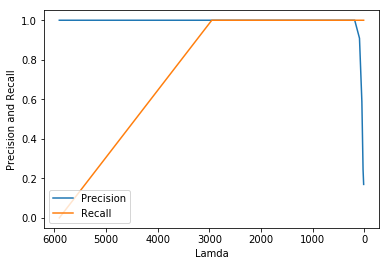

In [12]:
import matplotlib.pyplot as plt
plt.plot(model.lamdaList, model.precision)
plt.plot(model.lamdaList, model.recall)
plt.ylabel('Precision and Recall')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Precision', 'Recall'], loc='lower left')
plt.show()
#plt.savefig('RMSEvsLamda.png')

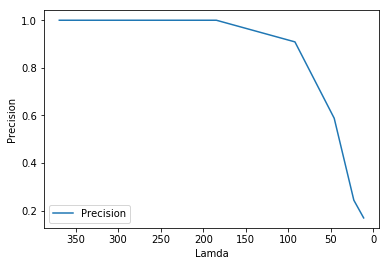

In [61]:
plt.plot(model.lamdaList[4:], model.precision[4:])
plt.ylabel('Precision')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Precision'], loc='lower left')
plt.show()
#plt.savefig('RMSEvsLamda.png')

In [16]:
# NON ZERO Count
print np.count_nonzero(W), np.count_nonzero(WS)

59 10


In [21]:
print model.Lamda
sModel = Lasso(X, Y, W, B, model.Lamda)

11.5335472512
Lamda:  11.5335472512
LOSS: 390362.832835
LOSS: 408400.572284
Precision:  0.126582278481
Recall:  1.0


In [28]:
newPList = []
for i in range(10):
    sModel.fit()
    newPrec = np.count_nonzero(sModel.W[:10])/(float)(np.count_nonzero(sModel.W))
    newPList.append(newPrec)
    print 'Precision: ', np.count_nonzero(sModel.W[:10])/(float)(np.count_nonzero(sModel.W))
    print 'Recall: ', np.count_nonzero(sModel.W[:10])/(float)(k) 

Lamda:  11.5335472512
LOSS: 416584.173443
Precision:  0.125
Recall:  1.0
Lamda:  11.5335472512
LOSS: 421286.07371
Precision:  0.126582278481
Recall:  1.0
Lamda:  11.5335472512
LOSS: 424020.691402
Precision:  0.128205128205
Recall:  1.0
Lamda:  11.5335472512
LOSS: 425534.115428
Precision:  0.12987012987
Recall:  1.0
Lamda:  11.5335472512
LOSS: 426290.914621
Precision:  0.131578947368
Recall:  1.0
Lamda:  11.5335472512
LOSS: 426699.512485
Precision:  0.131578947368
Recall:  1.0
Lamda:  11.5335472512
LOSS: 426896.375257
Precision:  0.135135135135
Recall:  1.0
Lamda:  11.5335472512
LOSS: 426963.775912
Precision:  0.135135135135
Recall:  1.0
Lamda:  11.5335472512
LOSS: 426996.511829
Precision:  0.135135135135
Recall:  1.0
Lamda:  11.5335472512
LOSS: 427012.212356
Precision:  0.135135135135
Recall:  1.0


In [23]:
print rmse(sModel.predict(X), Y)
print 'Precision: ', np.count_nonzero(sModel.W[:10])/(float)(np.count_nonzero(sModel.W))
print 'Recall: ', np.count_nonzero(sModel.W[:10])/(float)(k) 

8.27963725018
Precision:  0.126582278481
Recall:  1.0


In [26]:
# RMSE with new sigma: 8.27
print 'New Precision:', float(newPrec) - float(oldPrec)

New Precision: 0.0


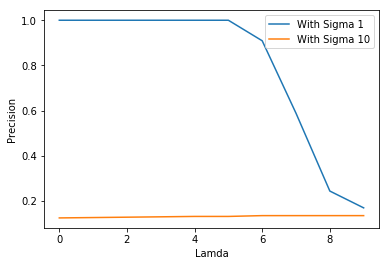

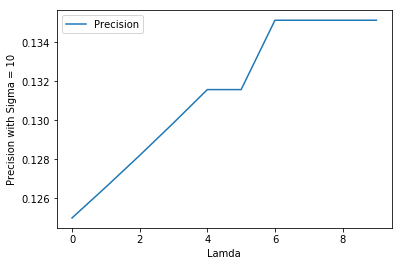

In [52]:
import matplotlib.pyplot as plt
plt.plot(model.precision)
plt.plot(newPList)
plt.ylabel('Precision')
plt.xlabel('Lamda')
plt.legend(['With Sigma 1', 'With Sigma 10'], loc='upper right')
plt.show()

plt.plot(newPList)
plt.ylabel('Precision with Sigma = 10')
plt.xlabel('Lamda')
plt.legend(['Precision', 'New Precision'], loc='upper left')
plt.show()